# Reinforcement Learning Homework

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menu bar, select Cell $\rightarrow$ Run All). You can also perform the two operations in one step (in the menu bar, select Kernel $\rightarrow$ Restart & Run All).

Make sure you fill in any place (or anywhere that you want in the code) that says `YOUR CODE HERE` or "YOUR ANSWER HERE", and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run). This is a reminder for you to complete all parts of the notebook. You can also send an incomplete notebook, but please remove all 'raise'-lines in any case.

You are not required to modify the code where the line `YOUR CODE HERE` does not appear. In fact you can modify the given function and code as you want, at your own risk! Those are just reminders.

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary).

Do not use different packages from the ones that are already imported! (the evaluation may fail otherwise)

Please use only google colab or jupyter to edit this notebook! Other software may save notebooks in a format that may interfere with the evaluation procedure.

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your code, since this is the way we will do it before evaluating your notebook!

Fill in your name and ID number (matricola) below:

In [1]:
NAME = 'Salim Benhamadi'
ID_number = int('2070573')

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# Homework II - Reinforcement Learning with Jackblack

The following homework allows you to review many concepts from the course of Reinforcement Learning.

In particular you will have to implement Monte Carlo algorithm, SARSA-$\lambda$ and SARSA-$\lambda$ with action-value function approximation. In order to test the implementations, we need an environment. Therefore you need also to complete the given code for a modified version of Blackjack game seen in class, invented by Jack from the car rental. In a burst of creativity, he called it **Jackblack** (with no reference to the actor).

Please, use google colab or jupyter to complete the notebook! Also be sure to deliver the notebook with the correct format (.ipynb). Corrupted notebooks or notebooks with cells missing may not be considered eligible (pun intended) for evaluation.

Needed imports below.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns; sns.set()

from copy import deepcopy
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

random.seed(ID_number)
np.random.seed(ID_number)

## Jackblack rules:

- The game is played with an infinite deck of cards (i.e. cards are sampled
with replacement)


- Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of _red_ (probability 1/3) or _black_ (probability
2/3).


- There are no aces or picture (face) cards in this game (no issues with usable aces!)


- At the start of the game both the player and the dealer draw one black
card (fully observed)


- Each turn the player may either **stick** or **hit**:
    - If the player hits then he draws another card from the deck
    - If the player sticks he receives no further cards and its turn ends


- The values of the player’s cards are added (if black card) or subtracted (if red
card)


- If the player’s sum exceeds 21, or becomes less than 1, then he “goes
bust” and loses the game, with a reward of -1


- If the player sticks then the dealer starts taking turns, same rules apply to him. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins, with a reward of 1; otherwise, the outcome – _win_ (reward 1),
_lose_ (reward -1), or _draw_ (reward 0) – is given by the player with the largest sum.

## Implementation of Jackblack environment

Follow the instructions givenn in each function and implement the missing ones so that the environment will work as expected.

As it usually happens with games, where we receive only a signle reward at the end of the episode, we will assume that there is no discounting, i.e. $\gamma=1$. This will hold throughout the entire notebook (hence you will not see that parameter)!

In [3]:
class Jackblack():

    def __init__(self):
        """
        Init the environment with its inner variables.
        The first state by picking a random card for the dealer and player.
        """
        dealer_score, _ = self.draw_card()
        player_score, _ = self.draw_card()
        self.state = {"dealer_score": dealer_score, "player_score": player_score}  # initial state
        self.actions = ("hit", "stick")

        init_state = self.state.copy()
        self.history = [init_state]  # game history, recording state and action of each step


    def step(self, action, verbose=False):
        """
        Compute a step in Easy21 game.

        Parameters
        ----------
        action : string, the action to pick
        verbose : bool, if True actions are printed

        Returns
        -------
        state : dict, the new state reached given the picked action
        reward : int, the reward we get in this new state
        done : bool, True if state is terminal, False if not
        """
        #print('ENV STEP ACTION', action)
        self.history.append({"player": action})

        # player hits
        if action == "hit":
            value, colour = self.draw_card()
            self.state['player_score'] = self.compute_new_score(value, colour, self.state['player_score'])
            if verbose:
                print(f'Player draws {colour} {value}')

            new_state = self.state.copy()
            self.history.append(new_state)

            if self.goes_bust(self.state['player_score']):
                # player goes bust
                reward = -1
                if verbose:
                    print('Player goes bust')
                    print('Player loses')
                return self.state, reward, True

            else:
                reward = 0
                return self.state, reward, False

        # player sticks
        else:
            if verbose:
                    print(f'Player stops')
            new_state = self.state.copy()
            self.history.append(new_state)

            state, reward = self.dealer_moves(verbose)
            return self.state, reward, True


    def draw_card(self): # TODO1
        """
        Each draw from the deck results in a value between 1 and 10 (uniformly
        distributed) with a colour of red (probability 1/3) or black (probability 2/3).

        Returns
        -------
        value : int, the value of the card
        colour : string, the colour of the card, "red" or "black"
        """
        # YOUR CODE HERE
        value = random.randint(1, 10)
        colour = np.random.choice(['red','black'], size = 1, p=(1/3,2/3))[0]
        return value, colour


    def goes_bust(self, score): # TODO2
        """
        Check if the player/dealer went bust

        Parameters
        ----------
        score : int, the score to check

        Returns
        -------
        bool : True if score is outside the prescribed range
        """
        # YOUR CODE HERE
        return ((score > 21) or (score < 1))


    def compute_new_score(self, value, colour, current_score): # TODO3
        """
        Compute the new score given the value and the colour of the drawn card.

        Parameters
        ----------
        value : int, the card's value
        colour : string, the card's colour
        current_score : int, the score to update

        Returns
        -------
        new_score : int, updated score
        """
        # YOUR CODE HERE
        if colour == "black":
            new_score = current_score + value
        elif colour == "red":
            new_score = current_score - value
        return new_score


    def dealer_moves(self, verbose=True):
        """
        Fixed dealer policy.

        Parameters
        ----------
        verbose : bool, if True actions are printed

        Returns
        -------
        state : state, the terminal state of the whole game sequence
        reward : int, the reward obtained at the end of the game sequence
        """
        # dealer hits as long as his score is < 17
        while self.state['dealer_score'] < 17:
            value, colour = self.draw_card()
            self.state['dealer_score'] = self.compute_new_score(value, colour, self.state['dealer_score'])
            if verbose:
                print(f'Dealer draws {colour} {value}')

            new_state = self.state.copy()
            self.history.append({"dealer": "hit"})
            self.history.append(new_state)


            if self.goes_bust(self.state['dealer_score']):
                # dealer goes bust, player wins
                if verbose:
                    print('Dealer goes bust')
                    print('Dealer loses')
                reward = 1
                return self.state, reward

        self.history.append({"dealer": "stick"})

        player_score = self.state['player_score']
        dealer_score = self.state['dealer_score']

        # score > 17 -> dealer sticks
        if verbose:
            print('Dealer stops')
        if dealer_score < player_score: # player wins
            reward = 1
            if verbose:
                print('Player wins')
            return self.state, reward
        if dealer_score == player_score: # draw
            reward = 0
            if verbose:
                print('Draw')
            return self.state, reward
        if dealer_score > player_score: # player loses
            reward = -1
            if verbose:
                print('Dealer wins')
            return self.state, reward


    def print_score(self):
        """
        Print the current score of the game, both for player and dealer.
        """
        print('----------------')
        for player in self.state.items():
            print(player[0] + ': ' + str(player[1]))
        print('----------------')


In [4]:
# AT THIS POINT THE ENVIRONMENT MUST BE COMPLETED!

In [53]:
def plot_graph(policy, value, title):
    
    policy = policy.values
    
    dealer_showing = np.arange(1, 11)
    player_score = np.arange(1, 22)
    
    matrix = pd.DataFrame(value, columns=dealer_showing, index=player_score)
    
    fig = plt.figure(figsize=(20,10))
    sns.set()
    ax = sns.heatmap(matrix, annot=policy, fmt="s", cmap='coolwarm', vmin=-2, vmax=3)
    ax.xaxis.tick_top()
    ax.set_title(title)
    
    plt.xlabel("Dealer")
    plt.ylabel("Player")

Now explore some steps of a Jackblack game to check if the environment is coherent with the given rules. You can run the next cell multiple times.

In [6]:
env = Jackblack()
env.print_score()
env.step("hit", True)
env.print_score()
env.step("hit", True)
env.print_score()
env.step("stick", True)
env.print_score()

----------------
dealer_score: 5
player_score: 2
----------------
Player draws red 2
Player goes bust
Player loses
----------------
dealer_score: 5
player_score: 0
----------------
Player draws black 10
----------------
dealer_score: 5
player_score: 10
----------------
Player stops
Dealer draws black 10
Dealer draws black 10
Dealer goes bust
Dealer loses
----------------
dealer_score: 25
player_score: 10
----------------


## Monte-Carlo Control of Jackblack

Let's implement the classical version of Monte Carlo algorithm for action-value functions in order to find a good policy to win over the dealer.

The $\epsilon$-greedy policy should be implemented such that:
$$ \epsilon = \frac{N_0}{N_0 + c_1}  $$

where $c_1$ is the number of times the state has been encountered so far. You can (should!) try to understand how the parameter $N_0$ works to set a meaningful trade-off between exploration and exploitation.



In [7]:
class MC_Control():


    def __init__(self, N_0=100, n_episodes=100, lr=None):
        """
        Init the Monte Carlo control class with its inner variables.
        Try to understand how the N_0 parameter works!
        Both the Q-table and the counter are initialized to zero.
        The first episode is played with a random policy.
        """
        self.actions = ("hit", "stick")
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior!)
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        self.lr = lr                    # The learning rate: "how much" the Q-function is updated at each step

        self.Q = self.init_to_zeros()   # init Q function to zeros
        self.N = self.init_to_zeros()   # init N to zeros
        self.policy = "random"          # arbitrarily init the MC learning with a random policy


    def learn_q_value_function(self): # TODO4 (see other functions to understand how it should be done!)
        """
        Update the Q-function over all the episodes.
        From the second episode onwards you should use the epsilon greedy policy: see code below in order to
        understand how to do that!
        Pay attention to the <play_episode> function to understand how to implement this one!
        Do not forget to update both the Q-table and the counter.

        Returns
        ----------
        Q : dictionary of dictionaries. Every state is a key, whose value is another dictionary. The latter
        dictionary's keys are the actions, and the values are the Q-values for the corresponding state-action pair.
        {state: (action)}, Q-value for every state-action pair
        """
        # YOUR CODE HERE
        for i in range(self.n_episodes):
            # Running the an episode using the current policy
            episode = self.play_episode()
            # From the second episode onwards stating using the epsilon greedy policy
            self.policy = "e_greedy"
            for step in episode:
                state, action, reward, done = step
                #print('State', state)
                #print('Action', action)
                #print('Reward', reward)
                #  Updatinh the counter over all the episodes.
                self.increment_counter(state, action) # increment state-action counter
                #  Updating the Q-function over all the episodes.
                self.update_Q(state, action, reward)
        return self.Q


    def init_to_zeros(self):
        """
        Used to init the Q-function and the incremental counter N at 0 for every state-action pairs.

        Returns
        ----------
        lookup_table : {state: (action)}, a dictionary of states as keys and dictionaries as value, in which the actions
        are keys and corresponding Q-values are values
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  # initialize to 0 the Q-values!

        return lookup_table


    def play_episode(self):
        """
        Run a complete (from the initial state to the terminal state) Jackblack game sequence following the given policy.

        Returns
        ----------
        episode : [(state, action, reward, done)], a list of (state, action, reward, done)
        """
        env = Jackblack()                # init a game sequence
        state = env.state.copy()         # init state
        episode = []                     # list of the steps of the game sequence
        done = False
        while not done:
            # pick an action regarding the current state and policy
            #print('STATES', state)
            action = self.get_action(state)
            #print('ACTION', action)
            next_state, reward, done = deepcopy(env.step(action))
            step = (state, action, reward, done)  # store previous state
            state = next_state
            episode.append(step)

        return episode


    def update_Q(self, state, action, total_reward):  # TODO5
        """
        Update Q value towards the target.
        Even if this function does not return anything, you need to update <self.Q>!

        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        reward : int, the reward for that state-action pair
        """
        lookup_state = tuple(state.values())

        # The learning rate, decaying along with the number of times an action-state pair
        # has been explored. It represents the amount of modification we want to bring to
        # the Q value function.
        # YOUR CODE HERE
        alpha = (1 / self.get_state_action_counter(state, action))
        self.Q[lookup_state][action] +=  alpha* (total_reward - self.Q[lookup_state][action])


    def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.

        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        """
        lookup_state = tuple(state.values())
        self.N[lookup_state][action] += 1


    def random_policy(self):  # TODO6
        """
        Return an action following a random policy (clearly state free).

        Returns
        ----------
        action : string, random action
        """
        # YOUR CODE HERE
        action = random.choice(self.actions)
        return action


    def e_greedy_policy(self, state):  # TODO7
        """
        Return an action given by an epsilon greedy policy. Check all the given functions (also below)!
        They can be of great help!

        Parameters
        ----------
        state : dict, state where we pick the action

        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        # YOUR CODE HERE
        threshold = self.N_0/(self.N_0 + self.get_state_counter(state))
        if threshold > random.uniform(0, 1):
            action = random.choice(self.actions)
        else:
            action = self.get_action_w_max_value(state)
        return action



    def get_action(self, state):  # TODO8
        """
        Return an action following the policy prescribed by the inner value of the class (either "random" or "e_greedy").
        Use the functions above!

        Parameters
        ----------
        state : dict, state where we pick the action

        Returns
        ----------
        action : string, action from prescribed policy
        """
        # YOUR CODE HERE
        if self.policy == "random":
            action = self.random_policy()
        if self.policy == "e_greedy":
            action = self.e_greedy_policy(state)
        return action


    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q-value at a given state.

        Parameters
        ----------
        state : dict, state for the Q-function

        Returns
        ----------
        action : string, best action for the state according to Q-function
        """
        lookup_state = tuple(state.values())
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()      # randomly breaking ties
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get)
            return action


    def get_state_counter(self, state):
        """
        Return the counter for a given state.

        Parameters
        ----------
        state : dict or tuple with values

        Returns
        ----------
        counter : int, the number of times a state has been explored
        """
        try:
            counter = np.sum(list(self.N[state].values()))
        except TypeError:
            lookup_state = tuple(state.values())
            counter = np.sum(list(self.N[lookup_state].values()))

        return counter


    def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.

        Parameters
        ----------
        state : dict or tuple with values
        action : string

        Returns
        ----------
        counter : int, the number of times an action-state pair has been explored
        """
        try:
            counter = self.N[state][action]
        except TypeError:
            lookup_state = tuple(state.values())
            counter = self.N[lookup_state][action]

        return counter


    def optimal_policy(self):
        """
        Return the learned value-function and a dataframe with the optimal action for each state.

        Returns
        ----------
        max_Q : nd-array, the value-function
        df_pivot : dataframe, representing the best action for each state
        """
        max_Q = np.ndarray(shape=(21, 10))
        df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
        states = list(self.Q.keys())
        for i in range(len(states)):
            best_action = max(self.Q[states[i]], key=self.Q[states[i]].get)
            max_Q[states[i][1]-1][states[i][0]-1] = max(self.Q[states[i]].values())
            df.loc[i] = (states[i][0], states[i][1], best_action)
        df_pivot = df.pivot(index="player_score", columns="dealer_showing", values="best_action")

        return max_Q, df_pivot


def plot_table(table):
    """
    Plot the given value function in 3D.

    Parameters
    ----------
    table : nd-array, the value-function to be plotted
    """
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(projection = '3d')
    #ax = fig.gca(projection='3d')
    dealer_showing = np.arange(1, 11)
    player_score = np.arange(1, 22)
    dealer_showing, player_score = np.meshgrid(dealer_showing, player_score)
    # Plot the surface.
    surf = ax.plot_surface(dealer_showing, player_score, table, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # Customize plot
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    plt.xlabel('Dealer showing', fontsize=12)
    plt.ylabel('Player score', fontsize=12)
    plt.title('Value function', fontsize=16)
    plt.xticks(np.arange(1, 11))
    plt.yticks(np.arange(1, 22))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


mc = MC_Control(n_episodes=50_000)
mc.learn_q_value_function();
mcvalue, mcpol = mc.optimal_policy()

Now let's play 50_000 episodes and learn the Q-function with the Monte Carlo algorithm!

In [8]:
mc = MC_Control(n_episodes=50_000)
mc.learn_q_value_function();
mcvalue, mcpol = mc.optimal_policy()

Display the results!

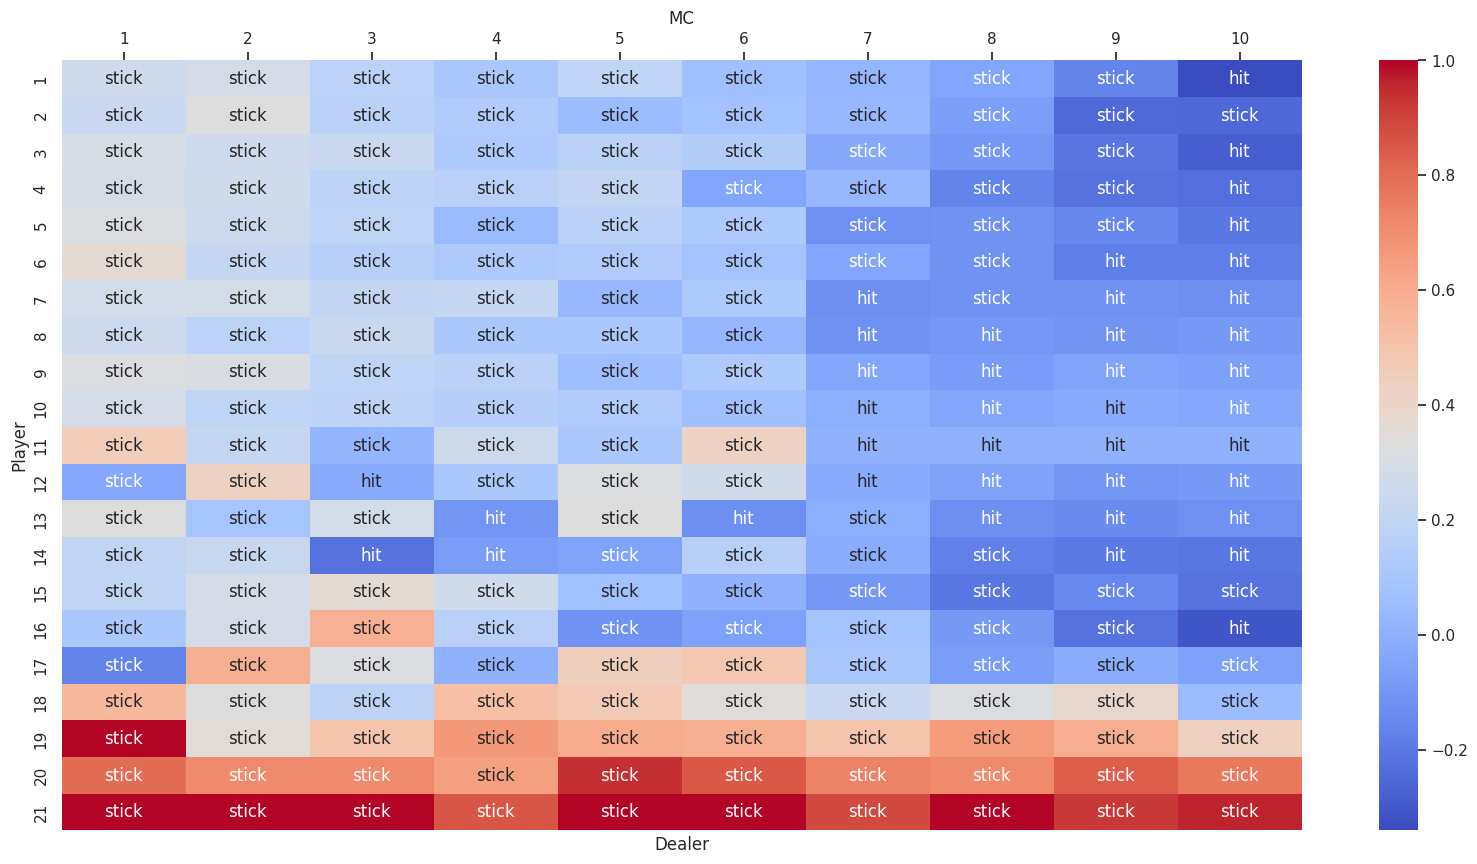

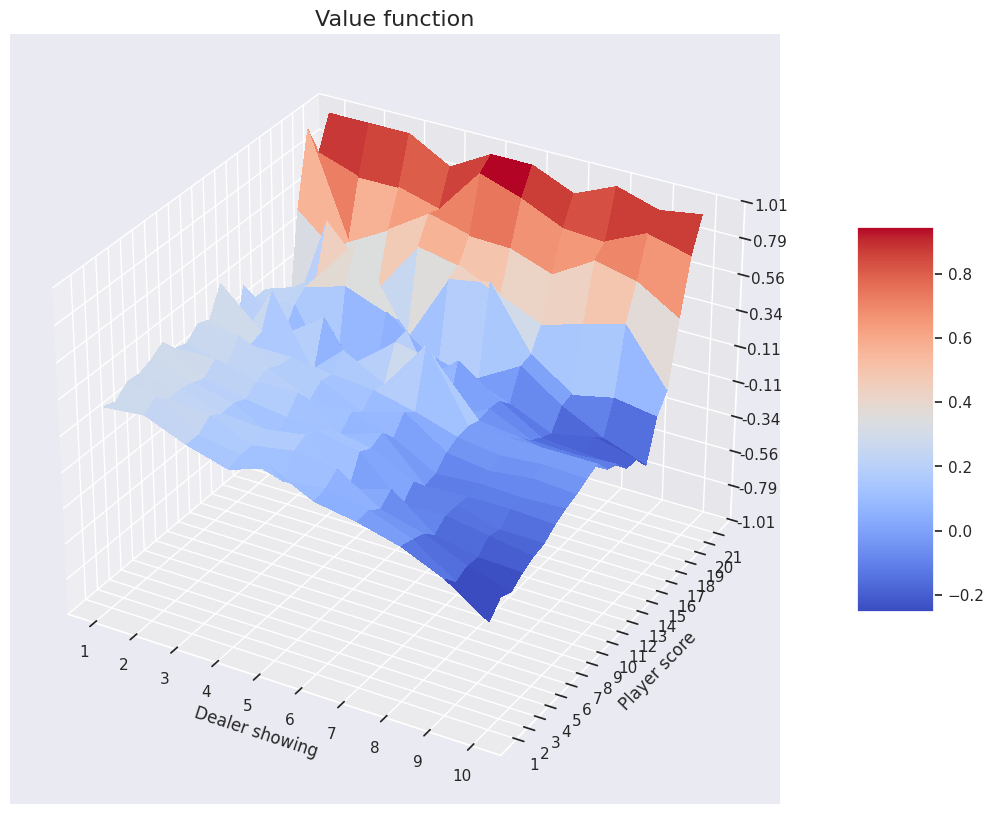

In [9]:
plot_graph(mcpol, mcvalue, "MC")
plot_table(mcvalue)

In [85]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from torch.distributions import Distribution
Distribution.set_default_validate_args(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm


# Define the PPO components
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
        self.loss = []

    def clear_memory(self):
        self.actions.clear()
        self.states.clear()
        self.logprobs.clear()
        self.rewards.clear()
        self.is_terminals.clear()
        self.loss.clear()

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, action_dim),
            nn.Softmax(dim=-1)
        )

        # critic: 2 hidden + output
        # self.value_layer = nn.Sequential(...)
        # 3 linear layers
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
        #features = self.fc(state)
        #print('features', features)
        state = state.float().to(device)
        #print('states got', state)
        action_probs = self.actor(state)
        #print('policy actor got', action_probs)
        action_probs = torch.clamp(action_probs, min=1e-6, max=1.0)  # Clamp to avoid invalid values
        #print('policy actor clamp', action_probs)
        value = self.critic(state)
        return action_probs, value

# PPO agent implementation
class PPO:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, clip_epsilon=0.2):
        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.memory = Memory()
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon

    def select_action(self, state):
        #print('SELECT ACTION ', state, torch.from_numpy(state))
        state_tensor = torch.FloatTensor(state).to(device)
        #print()
        #print('state tensor', state_tensor)
        action_probs, _ = self.policy(state_tensor)
        #print('action_probs', action_probs)
        #print()
        dist = Categorical(action_probs)
        action = dist.sample()
        self.memory.states.append(state_tensor)
        self.memory.actions.append(action)
        self.memory.logprobs.append(dist.log_prob(action))
        return action.item()

    def update(self):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + self.gamma * discounted_reward
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        #print('REWARDS', rewards, torch.var_mean(rewards, dim=-1, unbiased=False, keepdim=True)[0])
        #print(rewards.std())
        #print()
        rewards = (rewards - rewards.mean()) / (torch.var_mean(rewards, dim=-1, unbiased=False, keepdim=True)[-1] + 1e-8)  # Prevent division by zero

        old_states = torch.stack(self.memory.states).detach().to(device)
        old_actions = torch.tensor(self.memory.actions).detach().to(device)
        old_logprobs = torch.tensor(self.memory.logprobs).detach().to(device)

        for _ in range(5):  # Number of PPO updates
            action_probs, state_values = self.policy(old_states)
            action_probs = torch.clamp(action_probs, min=1e-6, max=1.0)  # Clamp again for safety
            dist = Categorical(action_probs)
            logprobs = dist.log_prob(old_actions)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            advantages = rewards - state_values.detach().squeeze()

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
            loss = -torch.min(surr1, surr2).mean() + 0.5 * (rewards - state_values.squeeze()).pow(2).mean()
            self.memory.loss.append(loss)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        #self.memory.clear_memory()


# Training the PPO agent
def train_ppo(env, ppo_agent, max_episodes=1000):
    total_reward = 0
    for episode in tqdm(range(max_episodes)):
        env = Jackblack()                # init a game sequence
        #state = env.state.copy()
        state = np.array(list(env.state.values()), dtype=np.float32)
        #print()
        #print('START STATES', state)
        done = False
        while not done:
            action = ppo_agent.select_action(state)
            #print('ACTION', action, env.actions[1 - action])

            next_state, reward, done = deepcopy(env.step(env.actions[action])) #
            step = (state, action, reward, done)  # store previous state #
            #state = next_state #
            #episode.append(step) #

            #next_state, reward, done = env.step(env.actions[action])
            #print('NEXT STATE', next_state, 'REWARD', reward)
            next_state = np.array(list(next_state.values()), dtype=np.float32)

            ppo_agent.memory.rewards.append(reward)
            ppo_agent.memory.is_terminals.append(done)

            state = next_state
            total_reward += reward

            ppo_agent.update()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")
            total_reward = 0
    return ppo_agent

In [35]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize environment and PPO agent
env = Jackblack()
state_dim = 2  # "dealer_score" and "player_score"
action_dim = 2  # "hit" or "stick"
ppo_agent = PPO(state_dim, action_dim)

# Train the agent
ppo_agent = train_ppo(env, ppo_agent, max_episodes=1500)

  0%|          | 0/1500 [00:00<?, ?it/s]

Episode 100, Total Reward: -2
Episode 200, Total Reward: 0
Episode 300, Total Reward: -6
Episode 400, Total Reward: -4
Episode 500, Total Reward: 1
Episode 600, Total Reward: -10
Episode 700, Total Reward: 20
Episode 800, Total Reward: -6
Episode 900, Total Reward: -12
Episode 1000, Total Reward: -7
Episode 1100, Total Reward: 2
Episode 1200, Total Reward: 22
Episode 1300, Total Reward: 1
Episode 1400, Total Reward: 0
Episode 1500, Total Reward: 2


In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize environment and PPO agent
env = Jackblack()
state_dim = 2  # "dealer_score" and "player_score"
action_dim = 2  # "hit" or "stick"
ppo_agent = PPO(state_dim, action_dim)

# Train the agent
ppo_agent = train_ppo(env, ppo_agent, max_episodes=3000)

  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 100, Total Reward: 7
Episode 200, Total Reward: 5
Episode 300, Total Reward: 6
Episode 400, Total Reward: 3
Episode 500, Total Reward: 18
Episode 600, Total Reward: 0
Episode 700, Total Reward: 14
Episode 800, Total Reward: 16
Episode 900, Total Reward: -2
Episode 1000, Total Reward: 0
Episode 1100, Total Reward: 6
Episode 1200, Total Reward: 2
Episode 1300, Total Reward: 2
Episode 1400, Total Reward: 14
Episode 1500, Total Reward: -20
Episode 1600, Total Reward: -9
Episode 1700, Total Reward: 4
Episode 1800, Total Reward: -16
Episode 1900, Total Reward: 20
Episode 2000, Total Reward: 10
Episode 2100, Total Reward: 8
Episode 2200, Total Reward: -2
Episode 2300, Total Reward: 14
Episode 2400, Total Reward: -12
Episode 2500, Total Reward: -6
Episode 2600, Total Reward: 7
Episode 2700, Total Reward: -2
Episode 2800, Total Reward: 18
Episode 2900, Total Reward: 2
Episode 3000, Total Reward: -12


In [88]:
def plot_graph(policy, value, title):
    
    policy = policy.values
    
    dealer_showing = np.arange(1, 11)
    player_score = np.arange(1, 22)
    
    matrix = pd.DataFrame(value, columns=dealer_showing, index=player_score)
    
    fig = plt.figure(figsize=(20,10))
    sns.set()
    ax = sns.heatmap(matrix, annot=policy, fmt="s", cmap='coolwarm', vmin=-10, vmax=10)
    ax.xaxis.tick_top()
    ax.set_title(title)
    
    plt.xlabel("Dealer")
    plt.ylabel("Player")

  0%|          | 0/210 [00:00<?, ?it/s]

[1.0, 1.0]
0.0 0.0
[1.0, 2.0]
1.0 0.0
[1.0, 3.0]
2.0 0.0
[1.0, 4.0]
3.0 0.0
[1.0, 5.0]
4.0 0.0
[1.0, 6.0]
5.0 0.0
[1.0, 7.0]
6.0 0.0
[1.0, 8.0]
7.0 0.0
[1.0, 9.0]
8.0 0.0
[1.0, 10.0]
9.0 0.0
[1.0, 11.0]
10.0 0.0
[1.0, 12.0]
11.0 0.0
[1.0, 13.0]
12.0 0.0
[1.0, 14.0]
13.0 0.0
[1.0, 15.0]
14.0 0.0
[1.0, 16.0]
15.0 0.0
[1.0, 17.0]
16.0 0.0
[1.0, 18.0]
17.0 0.0
[1.0, 19.0]
18.0 0.0
[1.0, 20.0]
19.0 0.0
[1.0, 21.0]
20.0 0.0
[2.0, 1.0]
0.0 1.0
[2.0, 2.0]
1.0 1.0
[2.0, 3.0]
2.0 1.0
[2.0, 4.0]
3.0 1.0
[2.0, 5.0]
4.0 1.0
[2.0, 6.0]
5.0 1.0
[2.0, 7.0]
6.0 1.0
[2.0, 8.0]
7.0 1.0
[2.0, 9.0]
8.0 1.0
[2.0, 10.0]
9.0 1.0
[2.0, 11.0]
10.0 1.0
[2.0, 12.0]
11.0 1.0
[2.0, 13.0]
12.0 1.0
[2.0, 14.0]
13.0 1.0
[2.0, 15.0]
14.0 1.0
[2.0, 16.0]
15.0 1.0
[2.0, 17.0]
16.0 1.0
[2.0, 18.0]
17.0 1.0
[2.0, 19.0]
18.0 1.0
[2.0, 20.0]
19.0 1.0
[2.0, 21.0]
20.0 1.0
[3.0, 1.0]
0.0 2.0
[3.0, 2.0]
1.0 2.0
[3.0, 3.0]
2.0 2.0
[3.0, 4.0]
3.0 2.0
[3.0, 5.0]
4.0 2.0
[3.0, 6.0]
5.0 2.0
[3.0, 7.0]
6.0 2.0
[3.0, 8.0]
7.0 2.0
[3.0

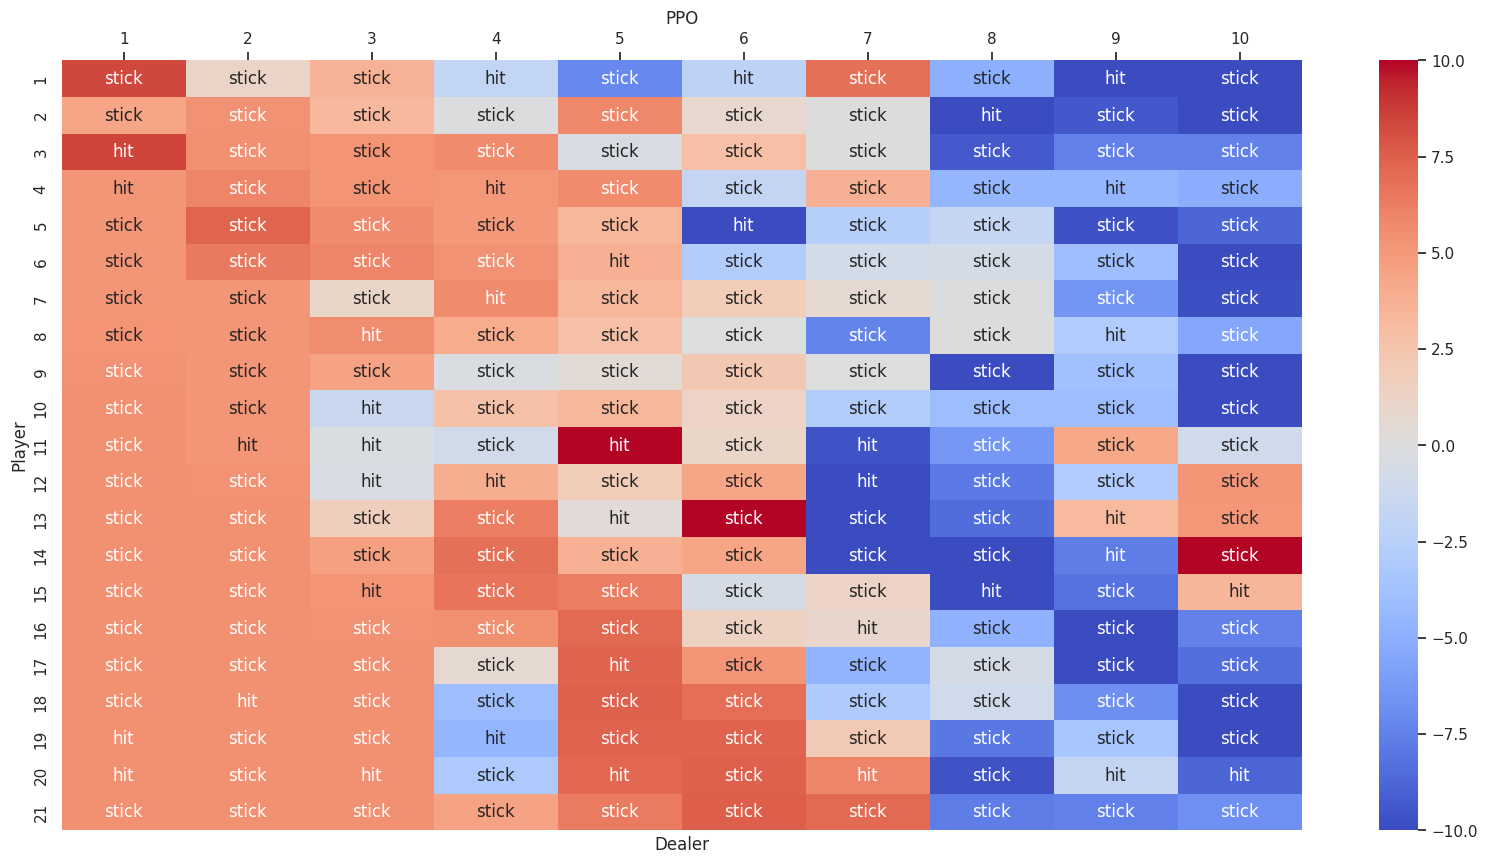

In [89]:
df_pivot, best_policy = optimal_policy(ppo_agent)
plot_graph(df_pivot, best_policy, "PPO")

In [91]:
ppo_agent.memory.loss

[tensor(0.2816, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(-0.1650, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(-0.1334, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2392, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2311, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1160, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(-0.0224, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(-0.1159, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(-0.1441, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1952, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2146, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(79398.8281, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(79340.1484, device='cuda:0', grad_fn=<AddBackward0>),
 

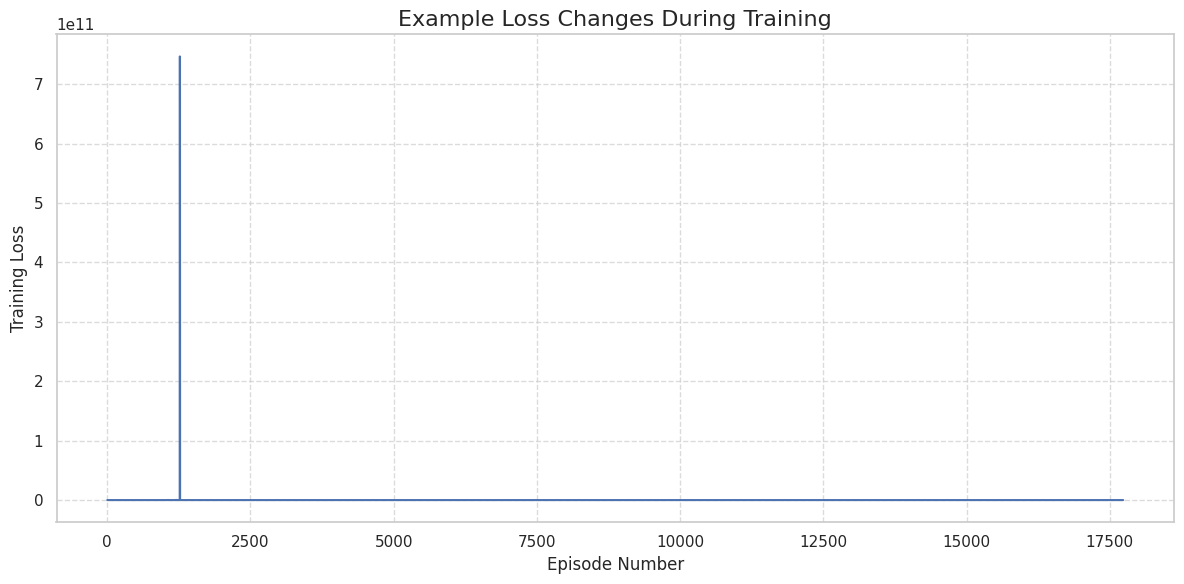

In [92]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def plot_loss_changes(losses, title="Loss Changes During Training", xlabel="Episode", ylabel="Loss"):

    # Convert the list of tensors to a numpy array for plotting
    losses_np = np.array([loss.item() for loss in losses])

    # Create a DataFrame for Seaborn
    import pandas as pd
    df = pd.DataFrame({
        xlabel: range(1, len(losses_np) + 1),
        ylabel: losses_np
    })

    # Set the style for the plot
    sns.set_style("whitegrid")

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=xlabel, y=ylabel)

    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    # Add grid lines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()


example_losses = ppo_agent.memory.loss

# Call the function to plot the losses
plot_loss_changes(example_losses, 
                  title="Example Loss Changes During Training",
                  xlabel="Episode Number",
                  ylabel="Training Loss")

Cumulative rewards example: [-1 -2 -2 -1 -1 -2 -2 -3 -3 -4]


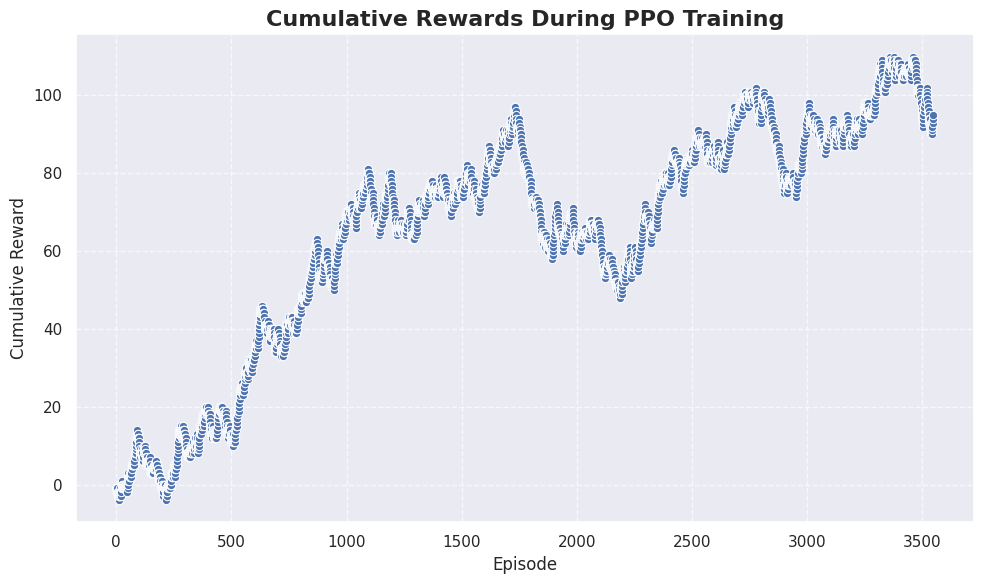

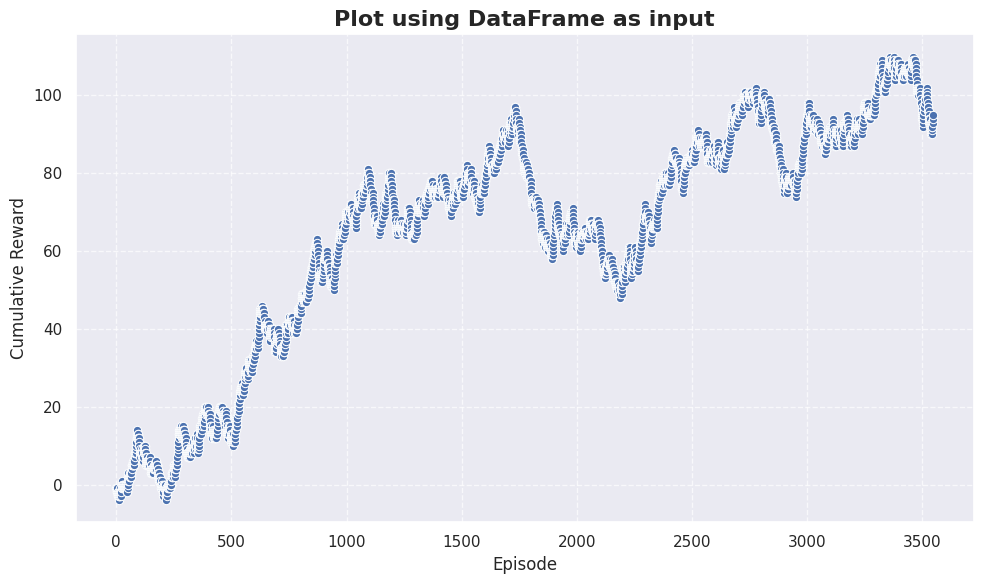

In [90]:
episode_rewards = np.array(ppo_agent.memory.rewards)
cumulative_rewards = calculate_cumulative_rewards(episode_rewards)

if cumulative_rewards is not None:
    print("Cumulative rewards example:", cumulative_rewards[:10]) #print just first 10 for demonstration
    plot_cumulative_rewards(episode_rewards)

    # Example of plotting with pandas DataFrame
    df_example = pd.DataFrame({'Episode': np.arange(1, len(cumulative_rewards) + 1), 'Cumulative Reward': cumulative_rewards})
    plot_cumulative_rewards(df_example,"Plot using DataFrame as input")

Cumulative rewards example: [-1 -1 -2 -2 -3 -2 -2 -1 -2 -1]


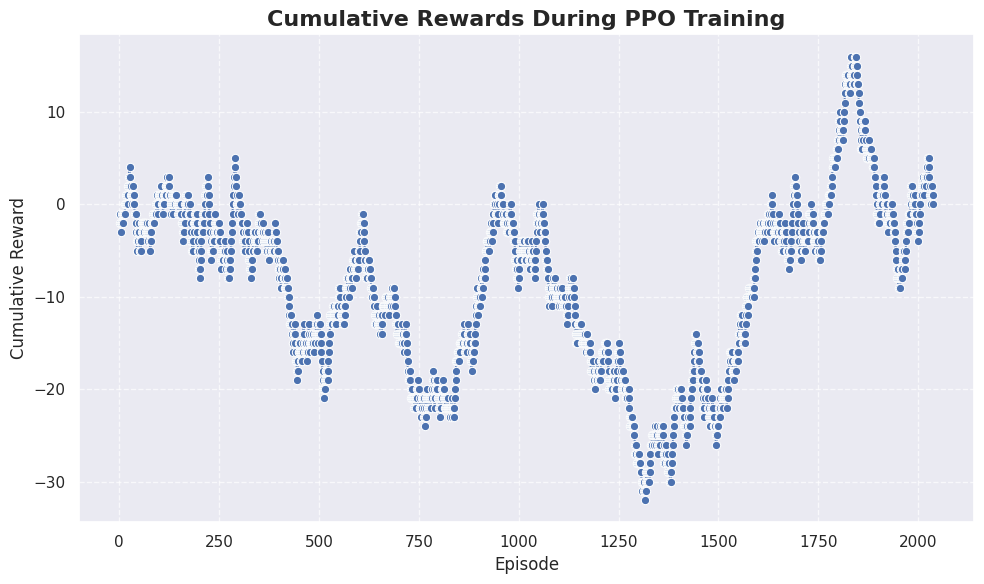

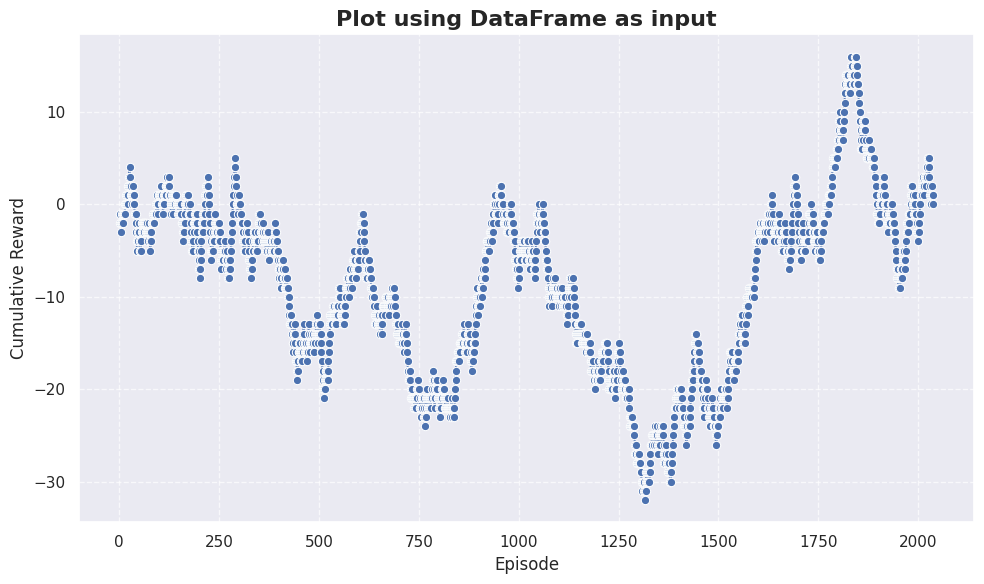

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_cumulative_rewards(rewards_array):
    """Calculates cumulative rewards from an array of episode rewards.

    Args:
        rewards_array: A 1D numpy array or list of rewards per episode.

    Returns:
        A 1D numpy array of cumulative rewards.
        Returns None if input is invalid
    """
    if not isinstance(rewards_array, (np.ndarray, list)):
        print("Invalid input: rewards_array must be a list or numpy array.")
        return None

    if isinstance(rewards_array,list):
         rewards_array = np.array(rewards_array)

    if rewards_array.ndim !=1:
        print("Invalid input: rewards_array must be 1 dimensional array or list.")
        return None

    cumulative_rewards = np.cumsum(rewards_array)
    return cumulative_rewards


def plot_cumulative_rewards(rewards_data, title="Cumulative Rewards During PPO Training"):
    """Plots cumulative rewards using Seaborn with styling.

    Args:
        rewards_data: A pandas DataFrame with 'Episode' and 'Cumulative Reward' columns, or 
                     a numpy array or list representing the rewards per episode
        title: The title of the plot.
    """
    if isinstance(rewards_data,(np.ndarray, list)):
        if isinstance(rewards_data,list):
            rewards_data = np.array(rewards_data)

        if rewards_data.ndim !=1:
            print("Data is not 1 dimentional, can not convert to DataFrame")
            return

        cumulative_rewards = calculate_cumulative_rewards(rewards_data)
        if cumulative_rewards is None:
             return
        df = pd.DataFrame({'Episode': np.arange(1, len(cumulative_rewards) + 1), 'Cumulative Reward': cumulative_rewards})
    elif isinstance(rewards_data, pd.DataFrame):
        df = rewards_data.copy()
        if not all(col in df.columns for col in ['Episode', 'Cumulative Reward']):
            print('DataFrame need to contain columns: "Episode", "Cumulative Reward"')
            return
    else:
        print("Type of data is not supported, provide numpy array, list or Pandas DataFrame")
        return


    sns.set_theme(style="darkgrid")  # Set dark grid style

    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size
    sns.lineplot(x='Episode', y='Cumulative Reward', data=df, marker='o', ax=ax)  # Add markers
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Cumulative Reward', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    fig.tight_layout() #adjust padding

    plt.show()



# Example usage:
#episode_rewards = np.random.normal(loc=1.0, scale=0.5, size=200) # Example rewards, you need use your reward data in real experiments
episode_rewards = np.array(ppo_agent.memory.rewards)
cumulative_rewards = calculate_cumulative_rewards(episode_rewards)

if cumulative_rewards is not None:
    print("Cumulative rewards example:", cumulative_rewards[:10]) #print just first 10 for demonstration
    plot_cumulative_rewards(episode_rewards)

    # Example of plotting with pandas DataFrame
    df_example = pd.DataFrame({'Episode': np.arange(1, len(cumulative_rewards) + 1), 'Cumulative Reward': cumulative_rewards})
    plot_cumulative_rewards(df_example,"Plot using DataFrame as input")

In [41]:
ppo_agent.policy( torch.FloatTensor([2.0, 4.0]).to(device))[1].item()

-0.33314085006713867

In [72]:
def optimal_policy(ppo_agent):
    env = Jackblack()
    best_policy = np.ndarray(shape=(21, 10))
    df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
    #np.array(list(env.state.values()), dtype=np.float32)
    #states = list(np.array(ppo_agent.memory.states, dtype=np.float32)) #list(self.Q.keys())
    states = [[float(i), float(j)] for i in range(1, 11) for j in range(1, 22)]
    for i in tqdm(range(len(states))):
        #best_action = max(self.Q[states[i]], key=self.Q[states[i]].get)
        action = ppo_agent.select_action(states[i])
        best_action = env.actions[action]
        
        print(states[i])
        print(states[i][1]-1, states[i][0]-1)
        critic_val = ppo_agent.policy( torch.FloatTensor(states[i]).to(device))[1].item()
        best_policy[int(states[i][1]-1)][int(states[i][0]-1)] = critic_val  #np.log1p(abs(critic_val)) * np.sign(critic_val)
        df.loc[i] = (states[i][0], states[i][1], best_action)
    df_pivot = df.pivot(index="player_score", columns="dealer_showing", values="best_action")

    return df_pivot, best_policy #max_Q,

df_pivot, best_policy = optimal_policy(ppo_agent)

  0%|          | 0/210 [00:00<?, ?it/s]

[1.0, 1.0]
0.0 0.0
[1.0, 2.0]
1.0 0.0
[1.0, 3.0]
2.0 0.0
[1.0, 4.0]
3.0 0.0
[1.0, 5.0]
4.0 0.0
[1.0, 6.0]
5.0 0.0
[1.0, 7.0]
6.0 0.0
[1.0, 8.0]
7.0 0.0
[1.0, 9.0]
8.0 0.0
[1.0, 10.0]
9.0 0.0
[1.0, 11.0]
10.0 0.0
[1.0, 12.0]
11.0 0.0
[1.0, 13.0]
12.0 0.0
[1.0, 14.0]
13.0 0.0
[1.0, 15.0]
14.0 0.0
[1.0, 16.0]
15.0 0.0
[1.0, 17.0]
16.0 0.0
[1.0, 18.0]
17.0 0.0
[1.0, 19.0]
18.0 0.0
[1.0, 20.0]
19.0 0.0
[1.0, 21.0]
20.0 0.0
[2.0, 1.0]
0.0 1.0
[2.0, 2.0]
1.0 1.0
[2.0, 3.0]
2.0 1.0
[2.0, 4.0]
3.0 1.0
[2.0, 5.0]
4.0 1.0
[2.0, 6.0]
5.0 1.0
[2.0, 7.0]
6.0 1.0
[2.0, 8.0]
7.0 1.0
[2.0, 9.0]
8.0 1.0
[2.0, 10.0]
9.0 1.0
[2.0, 11.0]
10.0 1.0
[2.0, 12.0]
11.0 1.0
[2.0, 13.0]
12.0 1.0
[2.0, 14.0]
13.0 1.0
[2.0, 15.0]
14.0 1.0
[2.0, 16.0]
15.0 1.0
[2.0, 17.0]
16.0 1.0
[2.0, 18.0]
17.0 1.0
[2.0, 19.0]
18.0 1.0
[2.0, 20.0]
19.0 1.0
[2.0, 21.0]
20.0 1.0
[3.0, 1.0]
0.0 2.0
[3.0, 2.0]
1.0 2.0
[3.0, 3.0]
2.0 2.0
[3.0, 4.0]
3.0 2.0
[3.0, 5.0]
4.0 2.0
[3.0, 6.0]
5.0 2.0
[3.0, 7.0]
6.0 2.0
[3.0, 8.0]
7.0 2.0
[3.0

In [73]:
best_policy

array([[16.0134182 ,  9.67378807, -0.09430265, -3.37965202, -4.17898321,
        -4.29786444, -4.29187584, -4.272089  , -4.25617123, -4.24672651],
       [13.15555763,  4.47950459, -1.92246151, -3.63328838, -4.03786421,
        -4.09957981, -4.10556507, -4.11017513, -4.11652946, -4.12525463],
       [10.85653019,  1.51639891, -2.75915337, -3.78326225, -4.00139332,
        -4.03033733, -4.02764511, -4.03079891, -4.03749466, -4.04461336],
       [ 8.23419857, -0.33314085, -3.24134874, -3.90417814, -3.99535275,
        -4.00708342, -4.00363064, -4.0022769 , -4.00683784, -4.01276493],
       [ 5.08536625, -1.82593155, -3.5324254 , -4.02559614, -4.00440025,
        -3.99040318, -3.99136639, -3.99207687, -3.99438381, -3.99984121],
       [ 1.64200234, -2.82999325, -3.73965931, -4.13993549, -4.04756832,
        -3.9811759 , -3.97907639, -3.98377132, -3.9878521 , -3.99202633],
       [-1.48757744, -3.40060568, -3.92431307, -4.21910954, -4.14783573,
        -3.987288  , -3.97050142, -3.97501326

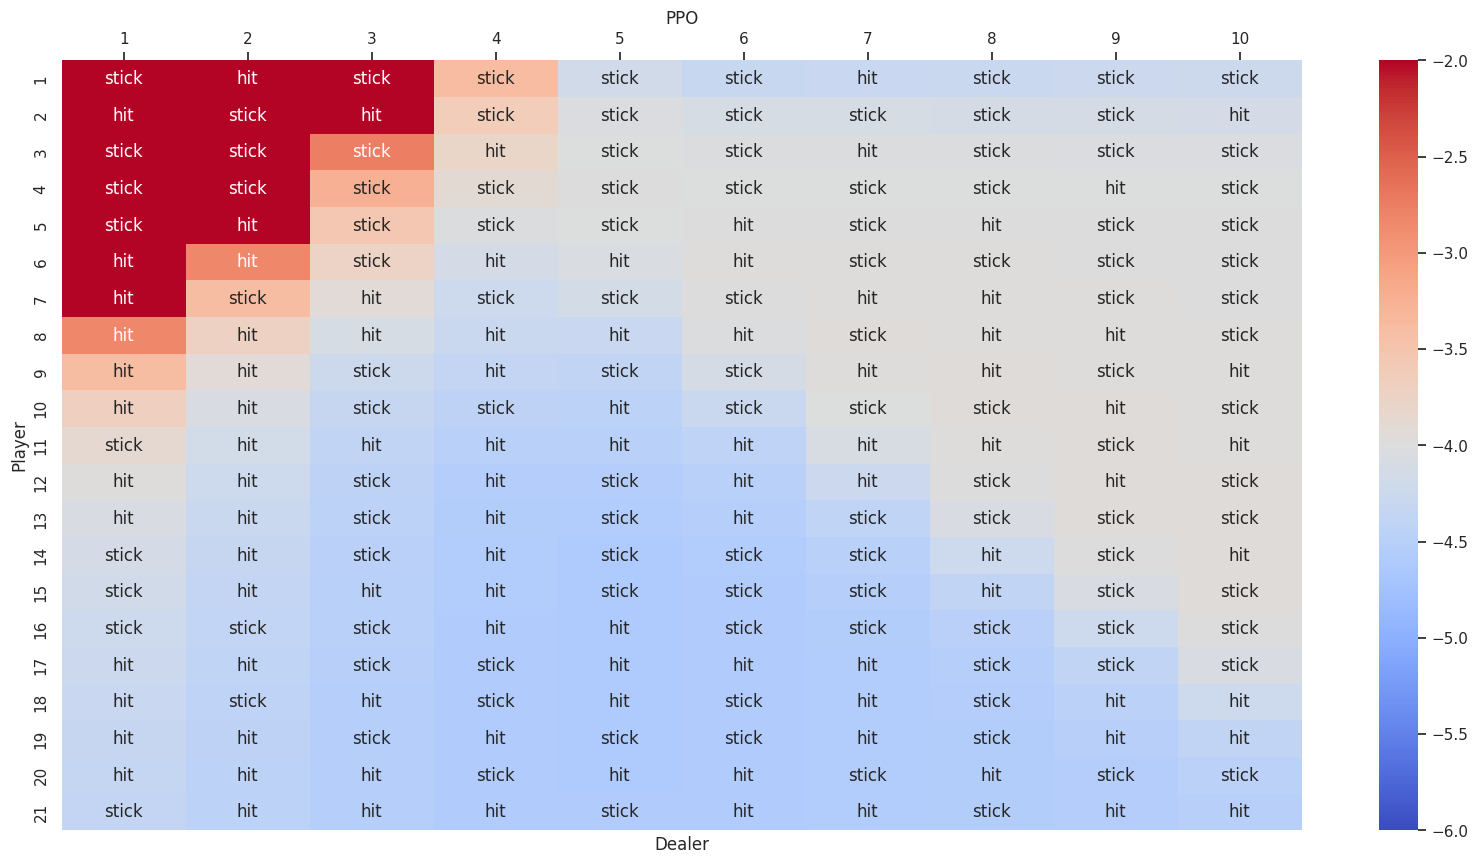

In [81]:
plot_graph(df_pivot, best_policy, "PPO")

In [ ]:
list(np.array(ppo_agent.memory.states, dtype=np.float32))

In [ ]:
var1 = list(np.array(ppo_agent.memory.states, dtype=np.float32))
np.asarray(var1, dtype="object")

In [ ]:
np.array(list(env.state.values()), dtype=np.float32)

## TD learning with SARSA(λ) in Jackblack

You shall now implement the SARSA(λ) algorithm, also using eligibility traces (both accumulating and replacing). Do you expect it will learn a better value function than Monte Carlo? Let's see. For the code below we can re-use some of the functions from the Monte Carlo implementation (but you should pay attention!).

The function should be implemented such that:
$$ \alpha = \frac{1}{c_2 + 1} $$

where $c_2$ is the number of times that state-action pair has been encountered so far, and alpha is the learning rate that multiplies the TD error in the update.

In [ ]:
import numpy as np

class SARSA():


    def __init__(self, lamb=.9, N_0=100, n_episodes=100, trace="accumulating"):
        """
        Init the SARSA class with its inner variables.
        Both the Q-table and the counter are initialized to zero.
        """
        self.actions = ("hit", "stick")
        self.lamb = lamb                # lambda parameter of the SARSA algorithm
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior!)
        self.trace = trace

        self.Q = self.init_to_zeros()                    # init Q function to zeros
        self.N = self.init_to_zeros()                    # init the counter traces to zeros
        self.eligibilty_traces = self.init_to_zeros()    # init eligibilty traces to zeros


    def learn_q_value_function(self):
        """
        Update the Q-function over all the episodes.

        Returns
        ----------
        Q : dictionary of dictionaries. Every state is a key, whose value is another dictionary. The latter
        dictionary's keys are the actions, and the values are the Q-values for the corresponding state-action pair.
        {state: (action)}, Q-value for every state-action pair
        """
        for i in range(self.n_episodes):
            self.eligibilty_traces = self.init_to_zeros()    # init eligibilty traces to zeros
            env = Jackblack()                                # init a game sequence
            state = env.state.copy()                         # init state
            action = self.e_greedy_policy(state)             # pick a first action
            self.increment_counter(state, action)

            done = False
            while not done:
                next_state, reward, done = deepcopy(env.step(action))

                if done:
                    next_action = None
                    delta = self.compute_delta(state, action, next_state, next_action, reward)

                else:
                    next_action = self.e_greedy_policy(next_state)
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                    self.increment_counter(next_state, next_action)

                self.increment_eligibility_traces(state, action)
                self.update_step(delta)

                action = next_action
                state = next_state

        return self.Q


    def init_to_zeros(self):
        """
        Used to init the Q-function and the incremental counter N at 0 for every state-action pairs.

        Returns
        ----------
        lookup_table : {state: (action)}, a dictionary of states as keys and dictionaries as value, in which the actions
        are keys and corresponding Q-values are values
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}

        return lookup_table


    def update_step(self, delta):  # TODO9
        """
        Update the Q value towards the target, and also the eligibility traces.
        Implement the correct procedure to update the Q-function and the eligibility traces, with given delta.
        Recall that here traces have already been accumulated/replaced, so there is no need to take care of that.

        Parameters
        ----------
        delta : float, the TD error for the current state-action pair
        """
        # Here is where the lambda parameter intervenes. The higher, the slower the eligibility trace
        # associated to a state-action will fade away.
        # YOUR CODE HERE
        for state in self.Q.keys():
            for action in self.actions:
                # Updating the Q value towards the target
                alpha = 1 / (self.get_state_action_counter(state, action) + 1)
                self.Q[state][action] += alpha * delta * self.eligibilty_traces[state][action]
                # Updating the eligibility trace with the given delta
                self.eligibilty_traces[state][action] *= self.lamb


    def compute_delta(self, state, action, next_state, next_action, reward):
        """
        Compute delta, the TD error.

        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        reward : int, the reward for the current state-action pair
        next_state : dict, the state we end up in after performing the action
        next_action : string, the action we take in next state following the (e_greedy) policy

        Returns
        ----------
        delta : float, the TD error
        """
        lookup_state = tuple(state.values())
        if next_action is None:
            delta = reward - self.Q[lookup_state][action]
        else:
            next_lookup_state = tuple(next_state.values())
            delta = reward + self.Q[next_lookup_state][next_action] - self.Q[lookup_state][action]
        return delta


    def increment_eligibility_traces(self, state, action):  # TODO10
        """
        Replace or accumulate the active trace.
        To choose between accumulating or replacing traces, query the corresponding inner variable of the class,
        and implement the update accordingly.
        You just need to accumulate or replace, the "fading" is taken into account in <update_step>!

        Parameters
        ----------
        state : dict, active state
        action : string, active action
        """
        # YOUR CODE HERE
        lookup_state = tuple(state.values())
        self.eligibilty_traces[lookup_state][action] += 1



    def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.

        Parameters
        ----------
        state : state, the current score
        action : string, the current score
        """
        lookup_state = tuple(state.values())
        self.N[lookup_state][action] += 1


    def random_policy(self):  # TODO11
        """
        Return an action following a random policy (clearly state free).

        Returns
        ----------
        action : string, random action
        """
        # YOUR CODE HERE
        action = random.choice(self.actions)
        return action


    def e_greedy_policy(self, state):  # TODO12
        """
        Return an action given an epsilon greedy policy.

        Parameters
        ----------
        state : dict, state where we pick the action

        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        # YOUR CODE HERE
        threshold = self.N_0/(self.N_0 + self.get_state_counter(state))
        if threshold > random.uniform(0, 1):
            action = random.choice(self.actions)
        else:
            action = self.get_action_w_max_value(state)
        return action


    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q-value at a given state.

        Parameters
        ----------
        state : dict, state for the Q-function

        Returns
        ----------
        action : string, best action for the state according to Q-function
        """
        lookup_state = tuple(state.values())
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get)
            return action


    def get_state_counter(self, state):
        """
        Return the counter for a given state.

        Parameters
        ----------
        state : dict or tuple with values

        Returns
        ----------
        counter : int, the number of times a state has been explored
        """
        try:
            counter = np.sum(list(self.N[state].values()))
        except TypeError:
            lookup_state = tuple(state.values())
            counter = np.sum(list(self.N[lookup_state].values()))

        return counter


    def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.

        Parameters
        ----------
        state : dict or tuple with values
        action : string

        Returns
        ----------
        counter : int, the number of times an action-state pair has been explored
        """
        try:
            counter = self.N[state][action]
        except TypeError:
            lookup_state = tuple(state.values())
            counter = self.N[lookup_state][action]

        return counter


    def optimal_policy(self):
        """
        Return the learned value-function and a dataframe with the optimal action for each state.

        Returns
        ----------
        max_Q : nd-array, the value-function
        df_pivot : dataframe, representing the best action for each state
        """
        max_Q = np.ndarray(shape=(21, 10))
        df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
        states = list(self.Q.keys())
        for i in range(len(states)):
            best_action = max(self.Q[states[i]], key=self.Q[states[i]].get)
            max_Q[states[i][1]-1][states[i][0]-1] = max(self.Q[states[i]].values())
            df.loc[i] = (states[i][0], states[i][1], best_action)
        df_pivot = df.pivot("player_score", "dealer_showing", "best_action")

        return max_Q, df_pivot

In [ ]:
# AT THIS POINT THE SARSA CLASS MUST BE COMPLETED!

Now let's play 50_000 episodes and learn the Q-function with the SARSA algorithm!

In [ ]:
sarsa = SARSA(n_episodes=50_000)
sarsa.learn_q_value_function();
sarsavalue, sarsapol = sarsa.optimal_policy()

Display the results!

In [ ]:
plot_graph(sarsapol, sarsavalue, "SARSA")
plot_table(sarsavalue)

## Linear Value Approximation in Jackblack

Even if our environment is not that complicated, and has a very limited number of states and actions, introducing a linear approximation for the Q-function may be beneficial, especially if we restrict the number of episode to 50_000 (which is not that high).

In the code below you shall implement the linear value approximation of the SARSA(λ) algorithm, where features are overlapped! In particular, the tile coding for the player's sum is made of 6 features; each feature is active if the state lies in between the 2 values (extremes included):

$(1, 6), \ (4, 9), \ (7, 12), \ (10, 15), \ (13, 18), \ (16, 21)$

As you see, there are some states in which there is more than one active feature.

In [ ]:
class Value_Approximation():


    def __init__(self, lamb=.9, epsilon=0.05, n_episodes=100, lr=0.01, trace="accumulating"):
        """
        Init the SARSA approximation class with its inner variables.
        Features are created with the given function.
        Here the epsilon and learning rate parameters are given explicitly and fixed.
        Initial weights for the linear function approximation are sampled from a Gaussian.
        Both the Q-table and the counter are initialized to zero.
        """
        self.actions = ("hit", "stick")
        self.lamb = lamb                                  # lambda parameter of the SARSA algorithm
        self.n_episodes = n_episodes                      # number of episodes (games) to sample in order to make the agent learn
        self.trace = trace

        self.features = self.create_features()                        # make features
        self.n_features = len(self.features)
        self.theta = self.init_theta()                                # init theta randomly
        self.eligibilty_traces = np.zeros(self.n_features)            # init eligibilty traces to zeros

        self.alpha = lr
        self.epsilon = epsilon

        # Only used for plot in optimal policy
        self.Q = self.init_to_zeros()


    def learn_q_value_function(self):  # TODO13
        """
        Update the Q-function (i.e. the weights!) towards the target, and also the eligibility traces.
        This function always considers the epsilon greedy policy.
        Compute delta with the function below (to be implemented).
        Both the updates of the weights and eligibility traces are taken into account in <update_step>. Use it!
        """
        for i in range(self.n_episodes):
            self.eligibilty_traces = np.zeros(self.n_features)            # init eligibilty traces to zeros
            env = Jackblack()                                             # init a game sequence
            state = env.state.copy()                                      # init state
            action = self.e_greedy_policy(state)                          # pick a first action

            # YOUR CODE HERE
            done = False
            while not(done):
                next_state, reward, done = deepcopy(env.step(action))

                if done :
                    next_action = None
                    delta = self.compute_delta(state, action, next_state, next_action, reward)

                else:
                    next_action = self.e_greedy_policy(next_state)
                    delta = self.compute_delta(state, action, next_state, next_action, reward)

                self.update_step(delta, state, action)

                action = next_action
                state = next_state

    def init_theta(self):
        """
        Init the weights of the approximation function from a normal centered reduced gaussian distribution

        Returns
        ----------
        theta : nd-array, random weights for the approximation
        """

        mu, sigma = 0, 0.1 # mean and standard deviation
        theta = np.random.normal(mu, sigma, self.n_features)
        return theta


    def init_to_zeros(self):
        """
        Used to init the Q-function and the incremental counter N at 0 for every state-action pairs.

        Returns
        ----------
        lookup_table : {state: (action)}, a dictionary of states as keys and dictionaries as value, in which the actions
        are keys and corresponding Q-values are values
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}

        return lookup_table


    def create_features(self):
        """
        Create the features for linear function approximation. Overlapping tile coding.

        Returns
        ----------
        features : list of tuples, each tuple is a combination of features (dealer_feature, player_feature, action)
        """

        dealer = [(1, 4), (4, 7), (7, 10)]
        player = [(1, 6), (4, 9), (7, 12), (10, 15), (13, 18), (16, 21)]  # Overlapping features!
        actions = ["hit", "stick"]
        features = []
        for d in dealer:
            for p in player:
                for a in actions:
                    features.append((d, p, a))
        return features


    def update_step(self, delta, state, action):  # TODO14
        """
        Update the weights of the linear function towards the optimality, and also the eligibility traces.
        According to the inner variable of the class, implement the correct version of the trace.
        Here you need to accumulate or replace, but also to implement the "fading" mechanism!

        Parameters
        ----------
        delta : float, the TD error for the given state-action pair
        state : dict, the current state
        action : string, the current action
        """
        lookup_state = tuple(state.values())
        index_associated_features = []
        for i, feature in enumerate(self.features):
            if (feature[0][0] <= lookup_state[0] <= feature[0][1]) and \
               (feature[1][0] <= lookup_state[1] <= feature[1][1]) and \
               (action == feature[2]):
                index_associated_features.append(i)

        # Update eligibility traces here! Both accumulating and replacing version.
        # YOUR CODE HERE
        for i in index_associated_features:
            self.eligibilty_traces[i] = self.lamb * self.eligibilty_traces[i] + 1
            self.theta[i] = self.theta[i] + self.alpha * delta * self.eligibilty_traces[i]


    def compute_delta(self, state, action, next_state, next_action, reward):  # TODO15
        """
        Compute delta, the TD error, with function approximation! You need to use phi (which is given)!
        Recall the formula of the TD error under function approximation.

        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        reward : int, the reward for the current state-action pair
        next_state : dict, the state we end up in after performing the action
        next_action : string, the action we take in next state following the policy

        Returns
        ----------
        delta : float, the TD error
        """
        lookup_state = tuple(state.values())
        # YOUR CODE HERE
        if next_action is None:
            delta = reward - self.phi(lookup_state, action)
        else:
            next_lookup_state = (next_state["dealer_score"], next_state["player_score"])
            delta = reward + self.phi(next_lookup_state, next_action) - self.phi(lookup_state, action)
        return delta



    def phi(self, state, action):
        """
        The linear function phi, which compute the Q-value for a given state-action pair. Implements tile coding.

        Parameters
        ----------
        state : tuple, the current state
        action : string, the current action

        Returns
        ----------
        q_value: float, the q value associated to a given state-action pair.

        """
        index_associated_features = []
        for i, feature in enumerate(self.features):
            if (feature[0][0] <= state[0] <= feature[0][1]) and \
               (feature[1][0] <= state[1] <= feature[1][1]) and \
               (action == feature[2]):
                index_associated_features.append(i)
        q_value = np.sum(np.take(self.theta, index_associated_features, axis=0))

        return q_value


    def random_policy(self):  # TODO16
        """
        Return an action following a random policy (clearly state free).

        Returns
        ----------
        action : string, random action
        """
        # YOUR CODE HERE
        action = random.choice(self.actions)
        return action


    def e_greedy_policy(self, state):  # TODO17
        """
        Return an action given an epsilon greedy policy.

        Parameters
        ----------
        state : dict, state where we pick the action

        Returns
        ----------
        action : string, action from epsilon greedy policy
        """
        # YOUR CODE HERE
        if self.epsilon > random.uniform(0, 1):
            action = random.choice(self.actions)
        else:
            action = self.get_action_w_max_value(state)

        return action


    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q-value at a given state.

        Parameters
        ----------
        state : dict, state for the Q-function

        Returns
        ----------
        action : string, best action for the state according to the approximated Q-function
        """
        try:
            lookup_state = tuple(state.values())
        except AttributeError:
            lookup_state = state
        if self.phi(lookup_state, "hit") == self.phi(lookup_state, "stick"):
            return self.random_policy()
        else:
            if self.phi(lookup_state, "hit") > self.phi(lookup_state, "stick"):
                return "hit"
            else:
                return "stick"


    def optimal_policy(self):
        """
        Return the learned value-function and a dataframe with the optimal action for each state.
        Note the use of phi!

        Returns
        ----------
        max_Q : nd-array, the value-function
        df_pivot : dataframe, representing the best action for each state
        """
        max_Q = np.ndarray(shape=(21, 10))
        df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
        states = list(self.Q.keys())
        for i in range(len(states)):
            best_action = self.get_action_w_max_value(states[i])
            max_Q[states[i][1]-1][states[i][0]-1] = self.phi(states[i], best_action)
            df.loc[i] = (states[i][0], states[i][1], best_action)
        df_pivot = df.pivot("player_score", "dealer_showing", "best_action")

        return max_Q, df_pivot

In [ ]:
# AT THIS POINT THE SARSA WITH APPROXIMATION CLASS MUST BE COMPLETED!

Now let's play 50_000 episodes and learn the approximated Q-function with the SARSA algorithm with function approximation!

In [ ]:
va = Value_Approximation(n_episodes=50_000)
va.learn_q_value_function()
vavalue, vapol = va.optimal_policy()

Display the results!

In [ ]:
plot_graph(vapol, vavalue, "ValueApprox")
plot_table(vavalue)

### TODO18
Comment the results you obtained with the three different procedures with regard to the optimal policy, the value-function and the computational burden. Do not describe the results, but try to say meaningful things about _why_ you obtained such results.
You do not need more than 7-10 lines.

Answer in the cell below.

In [ ]:
# YOUR CODE HERE
"""
In this Reinforcement Learning Assignment, we applied 3 different RL methods to a simple card game that we call JackBlack :

   * 1st Method Monte-Carlo Control: Upon implementing the algorithm into our jackblack environment and simulating 50,000 episodes,
 the Monte Carlo algorithm finds us an optimal policy through the iteratively updated action-value function,
 which also converges to optimality. and With a simple visual analysis of the graphs of the state-value functions with the Monte Carlo policy evaluation.
 the value goes up substantially when the player sum is 20 or greater, and with more games played the values of the rest of the states are flattened out ---> The more episodes it samples,
 the better it learns. It might be good in a simple game like JackBlack, however, in deeper environment sampling, 50k or more episodes might be infeasible…

 ---------------------- > To come over this major drawback, we need to start learning from incomplete episodes.

  * 2nd Method TD Learning with Sarsa(lambda) : In this case we  are going look at the Q value one step in the future to update the current Q value towards this future Q value estimation.
  In more simple terms, we adjust our current Q value to better match a future Q value estimation.
Thus, the Q value is updated on the fly, SARSA starts to learn from incomplete episodes and not at the end of the sampled episode like in MCC.
Compared to Monte-Carlo, an agent learning with SARSA doesn’t need to sample as much episodes to converge to the optimal policy thanks to its ability to learn from incomplete episodes.
That’s pretty useful when episodes are very long and sampling to many of them starts to become computationally too intensive.

 ---------------------- > In jackblack, there are 10*21*2 = 420 different state-action pairs. However, in real life, environments often have thousands of possible states and actions or even continuous states and actions domains.
In such environments it is not possible anymore to store or explicitly calculate each state-action combination hence the need of a Q value function approximation to solve the dimensionality problem.

 * 3rd Method Linear Function Approximation  : in the third case we are going to approximate the Q value function, rather than
 computing it for all the possible state-action pairs. The Q value function is not a lookup table anymore, but a function depending on some weights.
 so, we need to learn the best weights to get our approximation function as close as possible to the optimal Q value function which is clear in the obtained result.

"""